# [Trabajo práctico 1 - Torre de Hanoi](https://github.com/spardo83/iaa-tp1)

## Integrantes

- Gimenez, Pablo Eduardo
- Pardo, Sebastián
- Martín
- Jos
- Ricky
- Meoli, Lucas Pablo

## Introducción

En este notebook se desarrolla el Trabajo Práctico N.º 1 de la materia Inteligencia Artificial, perteneciente a la Carrera de Especialización en Inteligencia Artificial (CEIA).

El trabajo se divide en dos partes: en primer lugar, se implementan distintos algoritmos de búsqueda para resolver el problema de la Torre de Hanoi, utilizando el material provisto como base; y en segundo lugar, se abordan las preguntas teóricas planteadas por la cátedra.



# Algoritmos de búsqueda
**Autor: Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

Un algoritmo de búsqueda toma un problema de búsqueda como entrada y retorna una solución, o una indicación de falla.

La idea es buscar un camino que llegue al estado objetivo. Para ello, vamos a construir un árbol que irá avanzando por los estados del grafo hasta llegar al estado objetivo.

![arbol_de_hanoi](./img/tree_hanoi.png)

Cada nodo del árbol corresponde a un **estado** y las aristas corresponden a una **acción**. Es importante destacar que el árbol **NO** es el grafo de estados. El grafo describe todo el conjunto de estados y las acciones que permiten pasar de un estado a otro. El árbol describe el camino entre estos estados para alcanzar el objetivo.

Para poder aplicar los algoritmos, debemos definir las estructuras de datos necesarias para hacer seguimiento del árbol.

## Nodos del árbol

Los nodos del árbol están representados por los siguientes componentes:

- **State**: El estado del espacio de estados que corresponde al nodo.
- **Node Parent**: El nodo en el árbol de búsqueda que generó este nodo.
- **Action**: La acción que se aplicó al nodo padre para generar este nodo.
- **Path-Cost**: El costo de un camino desde el nodo inicial hasta este nodo.

Definamos el **Problema** de la Torre de Hanoi:

In [ ]:
from aima_libs.hanoi_states import ProblemHanoi, StatesHanoi

initial_state = StatesHanoi([5, 4, 3, 2, 1], [], [], max_disks=5)
goal_state = StatesHanoi([], [], [5, 4, 3, 2, 1], max_disks=5)

problem = ProblemHanoi(initial=initial_state, goal=goal_state)

Empezamos con la primera estructura, que implementamos con la clase `NodeHanoi`. Esta clase tiene implementados los siguientes:

**Atributos:**
* `state`: El estado que el nodo contiene. Representa un estado particular de ubicación de los discos.
* `parent`: Es el nodo padre de este nodo. Si el nodo es la raíz, es `None`.
* `action`: La acción que se aplicó al nodo padre para llegar a este nodo. Si es la raíz, es `None`.
* `path_cost`: El costo del camino desde la raíz del árbol hasta este nodo.
* `depth`: La profundidad del árbol en la que se encuentra el nodo. Si es la raíz, es cero; si es un hijo de la raíz, es igual a 1, y así sucesivamente.

**Métodos:**
* `child_node()`: Genera un nodo hijo a partir de una acción.
* `expand()`: Expande la frontera de este nodo, devolviendo los nodos hijos al aplicar `expand`.
* `solution()`: Retorna en una lista la secuencia de acciones que van desde la raíz hasta este nodo.
* `path()`: Retorna una lista de nodos que van desde la raíz hasta este nodo.
* `generate_solution_for_simulator()`: Este método permite obtener una salida para simular con PyGame. En otro notebook profundizaremos más en este aspecto.

Además, tiene implementados métodos que nos permiten hacer diferentes operaciones en Python:

* Podemos comparar dos nodos para ver si son iguales (haciendo `node1 == node2`)
* Podemos preguntar si un nodo es mayor que otro (haciendo `node1 > node2`), lo que significa si el costo acumulado de un nodo es mayor que otro.
* Tenemos una representación en cadena del estado, por lo que cuando hacemos `print()` se observa el estado dentro del nodo con el texto `<Node >`.
* También podemos obtener un hash del estado con `hash(estado)`


In [ ]:
from aima_libs.tree_hanoi import NodeHanoi

In [ ]:
# Definimos la raíz del árbol
root = NodeHanoi(state=initial_state)

In [ ]:
print("El arbol tiene como raíz a:")
print(root)

Desde un nodo y con el problema definido, podemos encontrar la frontera, que es la separación entre el grafo que ya ha sido explorado por el algoritmo de búsqueda y aquel que aún no ha sido explorado.

![frontera_en_arbol_de_hanoi](./img/tree_hanoi_frontier.png)

### Expandir la frontera del nodo raíz

Expandimos la frontera del nodo raíz:


In [ ]:
lista_nodos_fronteras = root.expand(problem=problem)

In [ ]:
for nodos in lista_nodos_fronteras:
    print(nodos)

Los estados que corresponden a estos nuevos nodos son:

![state](./img/state_hanoi5.png)

Por lo tanto, el árbol para este problema se verá así:

![tree](./img/tree_hanoi2.png)

Es decir, se generan dos nodos nuevos con los siguientes estados:

- El disco verde (el más pequeño) se mueve a la varilla del medio.
- El disco verde (el más pequeño) se mueve a la varilla derecha.

Quedémonos con el nodo cuyo estado tiene el disco verde en la varilla del medio:

In [ ]:
next_node = lista_nodos_fronteras[0]

Ahora, veamos su estado:

---



In [ ]:
next_node.state

Vemos quién es el padre, que debería ser la raíz:





In [ ]:
next_node.parent

El costo acumulado desde la raíz hasta este nodo es:

In [ ]:
next_node.path_cost

Y la profundidad en la que nos encontramos en el árbol:

In [ ]:
next_node.depth

### Expandir la frontera del nodo siguiente




Expandimos ahora la frontera de este nodo:

In [ ]:
lista_nodos_fronteras2 = next_node.expand(problem=problem)

In [ ]:
for nodos in lista_nodos_fronteras2:
    print(nodos)

Veamos cómo quedó ahora el árbol:

![tree](./img/tree_hanoi3.png)

Observamos lo siguiente: se generaron tres nuevos nodos en la frontera. De estos, hay dos que llaman la atención.

- Hay un nodo cuyo estado es igual al del nodo padre. Esto ocurre porque, si movemos el disco verde de vuelta a la varilla de la izquierda, *"retornamos"* al estado inicial.
- Hay un nodo que tiene el mismo estado que el segundo nodo obtenido del padre.

Esto es importante de destacar: **múltiples nodos pueden tener el mismo estado**, pero el costo para llegar a ese nodo y la secuencia de acciones desde la raíz hasta ese nodo serán diferentes.

Veamos ahora el nodo cuyo estado no está repetido:

In [82]:
next_node2 = lista_nodos_fronteras2[0]

Vemos su estado:

In [83]:
next_node2.state

HanoiState: 5 4 3 | 2 | 1

Vemos quién es el padre:

In [84]:
next_node2.parent

<Node HanoiState: 5 4 3 2 |  | 1>

El costo acumulado desde la raíz hasta este nodo es:

In [85]:
next_node2.path_cost

2.0

Y la profundidad en la que estamos en el árbol:

In [86]:
next_node2.depth

2

Veamos el camino desde la raíz hasta este nodo:

In [87]:
for nodos in next_node2.path():
    print(nodos)

<Node HanoiState: 5 4 3 2 1 |  | >
<Node HanoiState: 5 4 3 2 |  | 1>
<Node HanoiState: 5 4 3 | 2 | 1>


Y las acciones que se aplicaron desde el inicio hasta este nodo:

In [88]:
for nodos in next_node2.solution():
    print(nodos)

Move disk 1 from 1 to 3
Move disk 2 from 1 to 2


## Colas

La pregunta es: ¿cómo hacemos para elegir cuál nodo seleccionar para explorar la frontera? Para ello necesitamos una estructura de datos que nos permita explorar la frontera. Esta estructura es vital para el algoritmo de búsqueda, ya que nos permite seleccionar qué nodo vamos a expandir primero. Como vimos en los videos, elegir el tipo de estructura para expandir es lo que define el tipo de algoritmo.

La frontera se expande usando **colas**, y tenemos tres tipos:

- Una cola **FIFO** (Primero entra, primero sale) que toma los nodos en el mismo orden en que se agregan.
- Una cola **LIFO** (Último en entrar, primero en salir, o "stack") que quita el nodo más reciente.
- Una **cola prioritaria** que quita primero los nodos con el mínimo costo, de acuerdo con una función de evaluación `f()`.

### FIFO

Veamos una implementación de cola FIFO usando una lista:

In [89]:
fifo = []

La implementación debe incorporar las siguientes funciones:

- **Add(Frontier)**: Inserta el nodo en su correspondiente lugar de la cola. En el caso de la FIFO, inserta los nodos en el orden en que van llegando, utilizando el método `insert()`.

In [90]:
fifo.insert(0, lista_nodos_fronteras[0])
fifo.insert(0, lista_nodos_fronteras[1])

for nodos in fifo:
    print(nodos)

<Node HanoiState: 5 4 3 2 |  | 1>
<Node HanoiState: 5 4 3 2 | 1 | >


- **Is-empty(frontier)**: Retorna `True` si no hay nodos en la frontera. En el caso de la implementación con una lista, podemos preguntar si la cantidad de elementos es cero.

In [91]:
print("La cola está vacia?")
if len(fifo) == 0:
    print("La cola esta vacía")
else:
    print("La cola tiene elementos")

La cola está vacia?
La cola tiene elementos


- **Pop(frontier)**: Quita el primer nodo en la cola. Con las listas, podemos usar el método `pop()`.

In [92]:
new_node = fifo.pop()
print(f"El nodo que sacamos es {new_node}")

El nodo que sacamos es <Node HanoiState: 5 4 3 2 | 1 | >


Podemos ver que, una vez sacado el nodo, el mismo ya no está en la fila, y que particularmente sacamos el primer nodo que entró:

In [93]:
print("Los nodos que quedan en la fila son:")
print(fifo)

Los nodos que quedan en la fila son:
[<Node HanoiState: 5 4 3 2 |  | 1>]


Si expandimos la frontera del nuevo nodo que tenemos, podemos agregarlo a la cola:

In [94]:
lista_nodos_fronteras2 = new_node.expand(problem=problem)

# Insertamos los nodos de frontera en el orden que nos fue presentado:
fifo.insert(0, lista_nodos_fronteras2[0])
fifo.insert(0, lista_nodos_fronteras2[1])
fifo.insert(0, lista_nodos_fronteras2[2])

In [95]:
for nodos in fifo:
    print(nodos)

<Node HanoiState: 5 4 3 2 |  | 1>
<Node HanoiState: 5 4 3 2 1 |  | >
<Node HanoiState: 5 4 3 | 1 | 2>
<Node HanoiState: 5 4 3 2 |  | 1>


- **Top(frontier)**: Podemos ver cuál es nuestro siguiente nodo sin sacarlo:

In [96]:
print(f"El siguiente nodo que podemos sacar es {fifo[-1]}")

El siguiente nodo que podemos sacar es <Node HanoiState: 5 4 3 2 |  | 1>


Este es el segundo nodo que introdujimos cuando agregamos la frontera de la raíz. Como vemos, se respeta el principio *"Primero entra, primero sale"*.

### LIFO

Ahora veamos cómo podemos implementar un **stack**. Esto también lo podemos hacer con una lista.

In [97]:
lifo = []

- **Add(Frontier)**: Inserta el nodo en su correspondiente lugar de la cola. En el caso de la LIFO, se inserta de forma apilada para que el último nodo que se inserte, esté listo para salir. Esto lo hacemos usando `append()`:

In [98]:
lifo.append(lista_nodos_fronteras[0])
lifo.append(lista_nodos_fronteras[1])

for nodos in lifo:
    print(nodos)

<Node HanoiState: 5 4 3 2 | 1 | >
<Node HanoiState: 5 4 3 2 |  | 1>


> ⚠️ **Nota**: Los nodos están ordenados de forma inversa al caso de la fila FIFO.

- **Is-empty(frontier)**: Retorna `True` si no hay nodos en la frontera. En el caso de la implementación con una lista, podemos preguntar si la cantidad de elementos es cero.

In [99]:
print("El stack está vacio?")
if len(lifo) == 0:
    print("El stack esta vacio")
else:
    print("El stack tiene elementos")

El stack está vacio?
El stack tiene elementos


- **Pop(frontier)**: Quita el primer nodo en la cola. Con las listas, usamos el método `pop()`.

In [100]:
new_node = lifo.pop()
print(f"El nodo que sacamos es {new_node}")

El nodo que sacamos es <Node HanoiState: 5 4 3 2 |  | 1>


Podemos ver que, una vez sacado el nodo, el mismo ya no está en la fila, y que particularmente sacamos el último nodo que entró:

In [101]:
print("Los nodos que quedan en la fila son:")
print(lifo)

Los nodos que quedan en la fila son:
[<Node HanoiState: 5 4 3 2 | 1 | >]


Si expandimos la frontera del nuevo nodo que tenemos, podemos agregarlo a la cola:

In [102]:
lista_nodos_fronteras2 = new_node.expand(problem=problem)

lifo.append(lista_nodos_fronteras2[0])
lifo.append(lista_nodos_fronteras2[1])
lifo.append(lista_nodos_fronteras2[2])

In [103]:
for nodos in lifo:
    print(nodos)

<Node HanoiState: 5 4 3 2 | 1 | >
<Node HanoiState: 5 4 3 | 2 | 1>
<Node HanoiState: 5 4 3 2 1 |  | >
<Node HanoiState: 5 4 3 2 | 1 | >


- **Top(frontier)**: Podemos ver cuál es nuestro siguiente nodo sin sacarlo:

In [104]:
print(f"El siguiente nodo que podemos sacar es {lifo[-1]}")

El siguiente nodo que podemos sacar es <Node HanoiState: 5 4 3 2 | 1 | >


Este es el último nodo que introdujimos cuando agregamos la frontera del nodo que sacamos de la cola. Como vemos, se respeta el principio *"Último entra, primero sale"*.

### Cola prioritaria

Por último, nos queda ver la cola prioritaria. Para ello, usaremos la librería `queue` que viene por defecto en Python. [Esta librería](https://docs.python.org/3/library/queue.html) implementa varias colas (incluidas las colas FIFO y LIFO). Particularmente, vamos a usar la clase `PriorityQueue`.

In [105]:
from queue import PriorityQueue

priority_queue = PriorityQueue()

- **Add(Frontier)**: Para esta cola, se debe pasar el nodo que queremos encolar, pero además debemos pasar un número que defina la prioridad en forma de tupla. Esta cola siempre extrae el nodo con el valor de prioridad más bajo.

In [106]:
priority_queue.put((4, lista_nodos_fronteras[0]))
priority_queue.put((2, lista_nodos_fronteras[1]))

Como vimos en clase, el valor que podemos guardar puede ser:

- El costo hasta ese nodo (`g(n)`),
- Una heurística (`h(n)`),
- O una combinación de ambas (`f(n) = g(n) + h(n)`).

En este caso usamos valores arbitrarios solo para ver el funcionamiento.

- **Is-empty(frontier)**: Retorna `True` si no hay nodos en la frontera. Podemos usar el método `empty()`:

In [107]:
print("La cola prioritaria está vacia?")
if priority_queue.empty():
    print("La cola prioritaria esta vacia")
else:
    print("La cola prioritaria tiene elementos")

La cola prioritaria está vacia?
La cola prioritaria tiene elementos


- **Pop(frontier)**: Quita el primer nodo en la cola usando el método `get()`. El nodo extraído será el de menor prioridad.

In [108]:
priority_value, new_node = priority_queue.get()
print(f"El nodo que sacamos es {new_node}, cuyo valor de prioridad es {priority_value}")

El nodo que sacamos es <Node HanoiState: 5 4 3 2 |  | 1>, cuyo valor de prioridad es 2


Si expandimos la frontera del nuevo nodo, podemos agregar los nuevos nodos generados a la cola:

In [109]:
lista_nodos_fronteras2 = new_node.expand(problem=problem)

priority_queue.put((1, lista_nodos_fronteras2[0]))
priority_queue.put((24, lista_nodos_fronteras2[1]))
priority_queue.put((54, lista_nodos_fronteras2[2]))

- **Top(frontier)**: Para ver el siguiente nodo sin sacarlo, podemos acceder directamente a la lista interna queue (aunque esto no es lo más recomendable en producción):

In [110]:
print(f"El siguiente nodo que podemos sacar es {priority_queue.queue[0][-1]}, el cual tiene prioridad {priority_queue.queue[0][0]}")

El siguiente nodo que podemos sacar es <Node HanoiState: 5 4 3 | 2 | 1>, el cual tiene prioridad 1


#### Cola prioritaria de AIMA

También tenemos implementada una cola prioritaria que permite usar una función de evaluación directamente, lo que simplifica bastante la gestión de prioridades. Esta implementación forma parte de la biblioteca `aima`.

In [111]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

priority_queue2 = AimaPriorityQueue()

Con esta cola, podemos:

- Definir si la prioridad es por el menor o mayor valor (`order='min'` o `order='max'`).
- Pasar una función `f()` que, dado un nodo, devuelva su prioridad.

Por ejemplo, para probar su funcionamiento, podemos definir una función que devuelva una prioridad aleatoria:

In [112]:
import random

def priority_func(x):
    return random.randint(1, 1000)

In [113]:
priority_queue2 = AimaPriorityQueue(order='min', f=priority_func)

- **Add(Frontier)**: Se puede usar el método `append()` para agregar un nodo individual:

In [114]:
priority_queue2.append(lista_nodos_fronteras[0])
priority_queue2.append(lista_nodos_fronteras[1])

También se puede usar `extend()` para agregar varios nodos de una sola vez:

In [115]:
priority_queue2.extend(lista_nodos_fronteras2)

Para ver los elementos dentro de la cola:

In [116]:
priority_queue2.heap.queue

[(52, <Node HanoiState: 5 4 3 2 | 1 | >),
 (69, <Node HanoiState: 5 4 3 | 2 | 1>),
 (832, <Node HanoiState: 5 4 3 2 |  | 1>),
 (979, <Node HanoiState: 5 4 3 2 | 1 | >),
 (370, <Node HanoiState: 5 4 3 2 1 |  | >)]

- **Is-empty(frontier)**: Verifica si la cola está vacía:

In [117]:
print("La cola prioritaria está vacia?")
if len(priority_queue2) == 0:
    print("La cola prioritaria esta vacia")
else:
    print("La cola prioritaria tiene elementos")

La cola prioritaria está vacia?
La cola prioritaria tiene elementos


- **Pop(frontier)**: Quita el nodo con menor prioridad:

In [118]:
priority_value, new_node = priority_queue2.pop()
print(f"El nodo que sacamos es {new_node}, cuyo valor de prioridad es {priority_value}")

El nodo que sacamos es <Node HanoiState: 5 4 3 2 | 1 | >, cuyo valor de prioridad es 52


- **Top(frontier)**: Podemos ver el siguiente nodo que será extraído con el método `peek()`:

In [119]:
print(f"El siguiente nodo que podemos sacar es {priority_queue2.peek()[-1]}, el cual tiene prioridad {priority_queue2.peek()[0]}")

El siguiente nodo que podemos sacar es <Node HanoiState: 5 4 3 | 2 | 1>, el cual tiene prioridad 69


### Conclusión

Todo lo que hemos visto hasta ahora *—desde cómo definimos el problema hasta cómo se define la cola—* son ejemplos de implementación. Estos sirven como base, pero cada persona o proyecto es libre de usar estas soluciones o implementar las propias, de acuerdo a las necesidades del problema o del entorno en el que se esté trabajando.

----

## Búsqueda Primero en Anchura

Con todo lo que fuimos implementando, ahora podemos aplicar un algoritmo de búsqueda. Observá todo lo que tuvimos que definir e implementar previamente para poder llegar hasta este punto.

Vamos a implementar el algoritmo de **búsqueda primero en anchura (Breadth-First Search)**, tal como vimos en el video. Este algoritmo comienza desde la raíz y va expandiendo todos los nodos nivel por nivel utilizando una cola **FIFO**.

![breadth_first_search](./img/breadth_first_search.png)

### Probamos con menos discos

Empecemos con menos discos para probar cómo implementarlo y luego pasamos al caso con 5 discos:

In [120]:
# Inicializamos el problema
initial_state = StatesHanoi([3, 2, 1], [], [], max_disks=3)
goal_state = StatesHanoi([], [], [3, 2, 1], max_disks=3)
problem = ProblemHanoi(initial=initial_state, goal=goal_state)

frontier = [NodeHanoi(problem.initial)]  # Creamos una cola FIFO con el nodo inicial

find_solution = False

# Mientras que la cola no este vacia
while len(frontier) != 0:
    node = frontier.pop()  # Extraemos el primer nodo de la cola
    if problem.goal_test(node.state):  # Comprobamos si hemos alcanzado el estado objetivo
        last_node = node
        find_solution = True
        print("Encontramos la solución")
        break

    # Agregamos a la cola todos los nodos sucesores del nodo actual
    for next_node in node.expand(problem):
        frontier.insert(0, next_node)

if not find_solution:
    print("No se encontró la solución")

Encontramos la solución


Una vez encontrada, podemos analizar el último nodo del árbol y ver cuánto costó llegar a la solución:

In [121]:
print(f'Longitud del camino de la solución: {last_node.state.accumulated_cost}')
print(f'Profundidad del arbol donde se encontró la solución: {last_node.depth}')

Longitud del camino de la solución: 7.0
Profundidad del arbol donde se encontró la solución: 7


Probemos el mismo algoritmo con 4 discos:

In [122]:
#initial_state = StatesHanoi([4, 3, 2, 1], [], [], max_disks=4)
#goal_state = StatesHanoi([], [], [4, 3, 2, 1], max_disks=4)
#problem = ProblemHanoi(initial=initial_state, goal=goal_state)

#find_solution = False

#while len(frontier) != 0:
#    node = frontier.pop()
#    if problem.goal_test(node.state):
#        last_node = node
#        find_solution = True
#        print("Encontramos la solución")
#        break

#    for next_node in node.expand(problem):
#        frontier.insert(0, next_node)

#if not find_solution:
#    print("No se encontró la solución")

Este algoritmo puede tardar bastante tiempo (se puede interrumpir la ejecución si se desea), ya que ocurre un fenómeno que analizamos previamente al ver el árbol de búsqueda:

![tree](./img/tree_hanoi3.png)

Cuando expandimos un nodo de la frontera, los nuevos nodos pueden tener estados que ya fueron explorados en pasos anteriores, lo que hace que el algoritmo repita caminos y entre en bucles (aunque no infinitos, sí innecesariamente largos).

### Versión con control de estados explorados

Vamos a crear una variante del algoritmo que consume más memoria, pero evita explorar estados repetidos. Usamos para eso un `set`, estructura ideal para verificar rápidamente si un estado ya fue explorado:

In [123]:
initial_state = StatesHanoi([4, 3, 2, 1], [], [], max_disks=4)
goal_state = StatesHanoi([], [], [4, 3, 2, 1], max_disks=4)
problem = ProblemHanoi(initial=initial_state, goal=goal_state)

frontier = [NodeHanoi(problem.initial)]

explored = set()  # Almacena los estados que ya fueron explorados

find_solution = False
node_explored = 0

while len(frontier) != 0:
    node = frontier.pop()
    node_explored += 1

    explored.add(node.state) # Agregamos el estado al set de explorados

    if problem.goal_test(node.state):
        last_node = node
        find_solution = True
        print("Encontramos la solución")
        break

    # Agregamos a la cola todos los nodos sucesores del nodo actual
    for next_node in node.expand(problem):
        # Solo si el estado del nodo no fue explorado
        if next_node.state not in explored:
            frontier.insert(0, next_node)

if not find_solution:
    print("No se encontró la solución")

Encontramos la solución


Una vez que se encuentra la solución, podemos ver:

In [124]:
print(f'Longitud del camino de la solución: {last_node.state.accumulated_cost}')
print(f'Profundidad del arbol donde se encontró la solución: {last_node.depth}')

Longitud del camino de la solución: 15.0
Profundidad del arbol donde se encontró la solución: 15


Como todos los pasos tienen el mismo costo, la **búsqueda primero en anchura** garantiza que el camino encontrado es el más corto posible en términos de número de acciones. Es decir, el algoritmo encontró la solución en la mínima profundidad del árbol.

Además, podemos analizar el desempeño del algoritmo:

In [125]:
print(node_explored, "nodos se expandieron, correspondientes a", len(explored),"estados diferentes y", len(frontier), "nodos quedaron en la frontera")

216 nodos se expandieron, correspondientes a 71 estados diferentes y 52 nodos quedaron en la frontera


Podemos visualizar el camino desde el estado inicial hasta la solución:

In [126]:
for nodos in last_node.path():
    print(nodos)

<Node HanoiState: 4 3 2 1 |  | >
<Node HanoiState: 4 3 2 | 1 | >
<Node HanoiState: 4 3 | 1 | 2>
<Node HanoiState: 4 3 |  | 2 1>
<Node HanoiState: 4 | 3 | 2 1>
<Node HanoiState: 4 1 | 3 | 2>
<Node HanoiState: 4 1 | 3 2 | >
<Node HanoiState: 4 | 3 2 1 | >
<Node HanoiState:  | 3 2 1 | 4>
<Node HanoiState:  | 3 2 | 4 1>
<Node HanoiState: 2 | 3 | 4 1>
<Node HanoiState: 2 1 | 3 | 4>
<Node HanoiState: 2 1 |  | 4 3>
<Node HanoiState: 2 | 1 | 4 3>
<Node HanoiState:  | 1 | 4 3 2>
<Node HanoiState:  |  | 4 3 2 1>


Y las acciones que el agente debería aplicar para alcanzar el estado objetivo:

In [127]:
for act in last_node.solution():
    print(act)

Move disk 1 from 1 to 2
Move disk 2 from 1 to 3
Move disk 1 from 2 to 3
Move disk 3 from 1 to 2
Move disk 1 from 3 to 1
Move disk 2 from 3 to 2
Move disk 1 from 1 to 2
Move disk 4 from 1 to 3
Move disk 1 from 2 to 3
Move disk 2 from 2 to 1
Move disk 1 from 3 to 1
Move disk 3 from 2 to 3
Move disk 1 from 1 to 2
Move disk 2 from 1 to 3
Move disk 1 from 2 to 3


### Creando una función y resolviendo con 5 discos

Ahora que tenemos una implementación funcional, vamos a crear una función que aplique el algoritmo de **búsqueda primero en anchura (Breadth-First Search)**, y que retorne tanto la solución encontrada como algunas métricas de ejecución:

In [128]:
def breadth_first_search(number_disks=5):
    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = [NodeHanoi(problem.initial)] # Cola FIFO con el nodo inicial
    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_disk = None

    while len(frontier) != 0:
        node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_disk = node
            return node, metrics, goal_disk

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.insert(0, next_node)

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }
    return None, metrics, goal_disk

Ejecutamos con 5 discos:

In [129]:
solution, metrics, _ = breadth_first_search(number_disks=5)

Veamos algunas métricas:

In [130]:
for key, value in metrics.items():
    print(f"{key}: {value}")

solution_found: True
nodes_explored: 1351
states_visited: 233
nodes_in_frontier: 285
max_depth: 31
cost_total: 31.0


Para ver el camino completo desde el estado inicial hasta la solución:

In [131]:
for nodos in solution.path():
    print(nodos)

<Node HanoiState: 5 4 3 2 1 |  | >
<Node HanoiState: 5 4 3 2 |  | 1>
<Node HanoiState: 5 4 3 | 2 | 1>
<Node HanoiState: 5 4 3 | 2 1 | >
<Node HanoiState: 5 4 | 2 1 | 3>
<Node HanoiState: 5 4 1 | 2 | 3>
<Node HanoiState: 5 4 1 |  | 3 2>
<Node HanoiState: 5 4 |  | 3 2 1>
<Node HanoiState: 5 | 4 | 3 2 1>
<Node HanoiState: 5 | 4 1 | 3 2>
<Node HanoiState: 5 2 | 4 1 | 3>
<Node HanoiState: 5 2 1 | 4 | 3>
<Node HanoiState: 5 2 1 | 4 3 | >
<Node HanoiState: 5 2 | 4 3 | 1>
<Node HanoiState: 5 | 4 3 2 | 1>
<Node HanoiState: 5 | 4 3 2 1 | >
<Node HanoiState:  | 4 3 2 1 | 5>
<Node HanoiState: 1 | 4 3 2 | 5>
<Node HanoiState: 1 | 4 3 | 5 2>
<Node HanoiState:  | 4 3 | 5 2 1>
<Node HanoiState: 3 | 4 | 5 2 1>
<Node HanoiState: 3 | 4 1 | 5 2>
<Node HanoiState: 3 2 | 4 1 | 5>
<Node HanoiState: 3 2 1 | 4 | 5>
<Node HanoiState: 3 2 1 |  | 5 4>
<Node HanoiState: 3 2 |  | 5 4 1>
<Node HanoiState: 3 | 2 | 5 4 1>
<Node HanoiState: 3 | 2 1 | 5 4>
<Node HanoiState:  | 2 1 | 5 4 3>
<Node HanoiState: 1 | 2 | 5 4 

Y las acciones que el agente debería aplicar para llegar al objetivo:

In [132]:
for act in solution.solution():
    print(act)

Move disk 1 from 1 to 3
Move disk 2 from 1 to 2
Move disk 1 from 3 to 2
Move disk 3 from 1 to 3
Move disk 1 from 2 to 1
Move disk 2 from 2 to 3
Move disk 1 from 1 to 3
Move disk 4 from 1 to 2
Move disk 1 from 3 to 2
Move disk 2 from 3 to 1
Move disk 1 from 2 to 1
Move disk 3 from 3 to 2
Move disk 1 from 1 to 3
Move disk 2 from 1 to 2
Move disk 1 from 3 to 2
Move disk 5 from 1 to 3
Move disk 1 from 2 to 1
Move disk 2 from 2 to 3
Move disk 1 from 1 to 3
Move disk 3 from 2 to 1
Move disk 1 from 3 to 2
Move disk 2 from 3 to 1
Move disk 1 from 2 to 1
Move disk 4 from 2 to 3
Move disk 1 from 1 to 3
Move disk 2 from 1 to 2
Move disk 1 from 3 to 2
Move disk 3 from 1 to 3
Move disk 1 from 2 to 1
Move disk 2 from 2 to 3
Move disk 1 from 1 to 3


## Medición de performance

Por último, si nos preguntamos cómo medir la performance del algoritmo de búsqueda, Python nos ofrece algunas herramientas de *profiling*.

### Medir el tiempo de ejecución
Podemos utilizar `%%timeit` en notebooks de Jupyter para medir el tiempo de ejecución promedio de una celda:

In [133]:
%%timeit
solution, metrics, _ = breadth_first_search(number_disks=5)

37.7 ms ± 379 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


En una prueba típica, por ejemplo, podemos observar que la ejecución demora unos 60 milisegundos. Este valor dependerá de la máquina utilizada y solo será significativo si se compara con otros algoritmos ejecutados en las mismas condiciones.

### Medir el uso de memoria

Medir el uso de memoria es un poco más complejo. Una forma sencilla es monitorear el pico de consumo de memoria RAM durante la ejecución. Para esto podemos usar la biblioteca `tracemalloc`:

In [134]:
import tracemalloc

tracemalloc.start()

solution, metrics, _ = breadth_first_search(number_disks=5)

# Para medir memoria consumida usamos el pico de memoria
_, memory_peak = tracemalloc.get_traced_memory()
memory_peak /= 1024*1024
tracemalloc.stop()

print(f"Pico de memoria ocupada: {round(memory_peak, 2)} [MB]", )

Pico de memoria ocupada: 1.46 [MB]


Con esta estructura, tenemos un algoritmo funcional, evaluable en rendimiento y reutilizable. Desde acá podemos comparar esta implementación de búsqueda con otras variantes como:

- Búsqueda en profundidad primero
- Búsqueda con costo uniforme
- Búsqueda Greedy
- Búsqueda A*

# Implementación de otros algoritmos de búsqueda

### Funciones de ayuda

#### Guardar secuencia de movimientos

In [135]:
import json

def save_sequence(filename):
    path = goal_node.path()
    
    movimientos = []
    for node in path:
        if node.action:
            texto = str(node.action)  # Ej: "Move disk 1 from 1 to 3"
            partes = texto.split()
            movimientos.append({
                "disk": int(partes[2]),
                "peg_start": int(partes[4]),
                "peg_end": int(partes[6])
            })
    
    with open(f"simulator/{filename}.json", "w") as f:
        json.dump(movimientos, f, indent=4)

#### Guardar estado inicial

In [136]:

def save_initial_state(filename):
    initial_state_greedy = {
        "peg_1": [5, 4, 3, 2, 1],
        "peg_2": [],
        "peg_3": []
    }
    
    with open(f"simulator/{filename}.json", "w") as f:
        json.dump(initial_state_greedy, f, indent=4)

In [137]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import json
from IPython.display import clear_output

def simulate_movements(sequence_file, initial_state_file):
    # Cargar archivos
    with open(f"simulator/{initial_state_file}.json") as f:
        initial_state = json.load(f)
    
    with open(f"simulator/{sequence_file}.json") as f:
        sequence = json.load(f)
    
    # Estado actual
    state = {
        1: initial_state['peg_1'],  # invertimos para mostrar base abajo
        2: initial_state['peg_2'],
        3: initial_state['peg_3']
    }
    
    # Dibujar torres
    def draw_state(state, step_num=None, delay=1):
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        peg_positions = [1, 3, 5]
        peg_labels = {1: "Torre 1", 2: "Torre 2", 3: "Torre 3"}
        max_disks = sum(len(v) for v in state.values())
    
        # Dibujar varillas
        for peg_x in peg_positions:
            plt.plot([peg_x, peg_x], [0, max_disks + 1], 'k', lw=2)
    
        # Dibujar discos
        for peg, peg_x in zip(state, peg_positions):
            for level, disk in enumerate(state[peg]):
                width = disk * 0.4
                rect = patches.Rectangle((peg_x - width / 2, level), width, 0.8, color=f"C{disk % 10}")
                plt.gca().add_patch(rect)
                plt.text(peg_x, level + 0.3, str(disk), ha='center', va='center', color='white', fontsize=9)
    
        # Etiquetas
        plt.xticks(peg_positions, ["Torre 1", "Torre 2", "Torre 3"])
        plt.yticks([])
        if step_num is not None:
            plt.title(f"Paso {step_num}")
        plt.xlim(0, 6)
        plt.ylim(0, max_disks + 2)
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.show()
        time.sleep(delay)
    
    # Simular movimientos
    for i, move in enumerate(sequence, 1):
        draw_state(state, step_num=i)
        disk = move["disk"]
        origin = move["peg_start"]
        target = move["peg_end"]
        state[origin].remove(disk)
        state[target].append(disk)
    
    # Mostrar estado final
    draw_state(state, step_num="Final", delay=0)

## Búsqueda Primero en Profundidad

Cambio FIFO por LIFO (append en lugar de insert).

### Funcion

In [138]:
def depth_first_search(number_disks=5):
    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = [NodeHanoi(problem.initial)] # Cola con el nodo inicial
    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_node = None

    while len(frontier) != 0:
        node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_node = node
            return node, metrics, goal_node

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.append(next_node) # LIFO -> Append

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }

    return None, metrics, goal_node

### Ejecución

In [139]:
solution, metrics, _ = depth_first_search(number_disks=5)

Métricas:

In [140]:
for key, value in metrics.items():
    print(f"{key}: {value}")

solution_found: True
nodes_explored: 122
states_visited: 122
nodes_in_frontier: 63
max_depth: 121
cost_total: 121.0


Camino:

In [141]:
for nodos in solution.path():
    print(nodos)

<Node HanoiState: 5 4 3 2 1 |  | >
<Node HanoiState: 5 4 3 2 |  | 1>
<Node HanoiState: 5 4 3 2 | 1 | >
<Node HanoiState: 5 4 3 | 1 | 2>
<Node HanoiState: 5 4 3 |  | 2 1>
<Node HanoiState: 5 4 3 1 |  | 2>
<Node HanoiState: 5 4 3 1 | 2 | >
<Node HanoiState: 5 4 3 | 2 | 1>
<Node HanoiState: 5 4 3 | 2 1 | >
<Node HanoiState: 5 4 | 2 1 | 3>
<Node HanoiState: 5 4 | 2 | 3 1>
<Node HanoiState: 5 4 1 | 2 | 3>
<Node HanoiState: 5 4 1 |  | 3 2>
<Node HanoiState: 5 4 |  | 3 2 1>
<Node HanoiState: 5 4 | 1 | 3 2>
<Node HanoiState: 5 4 2 | 1 | 3>
<Node HanoiState: 5 4 2 |  | 3 1>
<Node HanoiState: 5 4 2 1 |  | 3>
<Node HanoiState: 5 4 2 1 | 3 | >
<Node HanoiState: 5 4 2 | 3 | 1>
<Node HanoiState: 5 4 2 | 3 1 | >
<Node HanoiState: 5 4 | 3 1 | 2>
<Node HanoiState: 5 4 | 3 | 2 1>
<Node HanoiState: 5 4 1 | 3 | 2>
<Node HanoiState: 5 4 1 | 3 2 | >
<Node HanoiState: 5 4 | 3 2 | 1>
<Node HanoiState: 5 4 | 3 2 1 | >
<Node HanoiState: 5 | 3 2 1 | 4>
<Node HanoiState: 5 | 3 2 | 4 1>
<Node HanoiState: 5 1 | 3 2

Performance:

In [142]:
%%timeit
solution, metrics, _ = depth_first_search(number_disks=5)

3.36 ms ± 24.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [143]:
import tracemalloc

tracemalloc.start()

solution, metrics, _ = depth_first_search(number_disks=5)

# Para medir memoria consumida usamos el pico de memoria
_, memory_peak = tracemalloc.get_traced_memory()
memory_peak /= 1024*1024
tracemalloc.stop()

print(f"Pico de memoria ocupada: {round(memory_peak, 2)} [MB]", )

Pico de memoria ocupada: 0.22 [MB]


## Heuristica

In [144]:
# 1 - Numero de discos fuera de ultima varilla

def heuristic_func1(node: NodeHanoi) -> int:

    return sum(len(rod) for rod in node.state.rods[:-1])

heuristic_func1(NodeHanoi(StatesHanoi([2], [], [3, 1], max_disks=3)))

1

In [145]:
# 2 - Numero de discos fuera de ultima varilla mas
#     numero de discos de la ultima varilla si no esta debajo el mas grande o numero de discos a partir del cual estan mal apilados

def heuristic_func2(node: NodeHanoi) -> int:

    rods = node.state.rods

    # Numero de discos fuera de ultima varilla

    not_in_last_rod = sum(len(rod) for rod in rods[:-1])

    # Analiza ultima varilla

    last_rod = rods[-1]
    wrong_in_last_rod = 0

    # Verifica si el disco de más abajo es el más grande

    if last_rod:

        if  last_rod[0] != max(max(rod) for rod in rods if rod):
            wrong_in_last_rod = len(last_rod)

        # Recorre desde abajo hacia arriba, y encuentra el primer disco mal apilado

        else:
            for i in range(len(last_rod) - 1):
                if last_rod[i] < last_rod[i + 1]:
                    wrong_in_last_rod = len(last_rod) - i - 1  # cantidad desde el disco mal puesto hasta arriba

    return not_in_last_rod + wrong_in_last_rod

heuristic_func2(NodeHanoi(StatesHanoi([2], [], [3, 1], max_disks=3)))

1

## Búsqueda Voraz

Uso cola prioritaria.

In [146]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

def greedy_search(number_disks=5, heuristic=heuristic_func1):
    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = AimaPriorityQueue(order='min', f=heuristic)  # Cola Prioritaria AIMA
    initial_node = NodeHanoi(problem.initial) # Nodo inicial
    frontier.append(initial_node) # Agrega el nodo inicial

    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_disk = None

    while len(frontier) > 0:
        _, node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_disk = node
            return node, metrics, goal_disk

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.append((next_node))

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }
    return None, metrics, goal_disk

## Búsqueda A*

Uso cola prioritaria.

In [147]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

def astar_search(number_disks=5, heuristic=heuristic_func1):

    def priority_func(node: NodeHanoi) -> int:
        return node.path_cost + heuristic(node)

    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = AimaPriorityQueue(order='min', f=priority_func)  # Cola Prioritaria AIMA
    initial_node = NodeHanoi(problem.initial) # Nodo inicial
    frontier.append(initial_node) # Agrega el nodo inicial

    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_disk = None

    while len(frontier) > 0:
        _, node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_disk = node
            return node, metrics, goal_disk

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.append((next_node))

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }
    return None, metrics, goal_disk

## Búsqueda por Dijkstra

In [148]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

def dijkstra_search(number_disks=5):


    def dijkstra_priority_func(node: NodeHanoi) -> int:
        return node.path_cost

    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = AimaPriorityQueue(order='min', f=dijkstra_priority_func)
    initial_node = NodeHanoi(problem.initial)
    frontier.append(initial_node)
    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_node = None

    while len(frontier) > 0:
        _, node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_node = node
            return node, metrics, goal_node

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        next_nodes = [next_node for next_node in node.expand(problem) if next_node.state not in explored]
        frontier.extend(next_nodes)

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }

    return None, metrics, goal_node

## Comparativa

In [149]:
import timeit
import tracemalloc
import tabulate

number_disks=5

t = timeit.Timer(lambda: breadth_first_search(number_disks))
time1 = t.timeit(number=10) / 10

t = timeit.Timer(lambda: depth_first_search(number_disks))
time2 = t.timeit(number=10) / 10

t = timeit.Timer(lambda: greedy_search(number_disks, heuristic=heuristic_func1))
time3 = t.timeit(number=10) / 10

t = timeit.Timer(lambda: greedy_search(number_disks, heuristic=heuristic_func2))
time4 = t.timeit(number=10) / 10

t = timeit.Timer(lambda: astar_search(number_disks, heuristic=heuristic_func1))
time5 = t.timeit(number=10) / 10

t = timeit.Timer(lambda: astar_search(number_disks, heuristic=heuristic_func2))
time6 = t.timeit(number=10) / 10

tracemalloc.start()
solution1, metrics1, _ = breadth_first_search(number_disks)
_, memory_peak1 = tracemalloc.get_traced_memory()
memory_peak1 /= 1024*1024
tracemalloc.stop()

tracemalloc.start()
solution2, metrics2, _ = depth_first_search(number_disks)
_, memory_peak2 = tracemalloc.get_traced_memory()
memory_peak2 /= 1024*1024
tracemalloc.stop()

tracemalloc.start()
solution3, metrics3, _ = greedy_search(number_disks, heuristic=heuristic_func1)
_, memory_peak3 = tracemalloc.get_traced_memory()
memory_peak3 /= 1024*1024
tracemalloc.stop()

tracemalloc.start()
solution4, metrics4, _ = greedy_search(number_disks, heuristic=heuristic_func2)
_, memory_peak4 = tracemalloc.get_traced_memory()
memory_peak4 /= 1024*1024
tracemalloc.stop()

tracemalloc.start()
solution5, metrics5, _ = astar_search(number_disks, heuristic=heuristic_func1)
_, memory_peak5 = tracemalloc.get_traced_memory()
memory_peak5 /= 1024*1024
tracemalloc.stop()

tracemalloc.start()
solution6, metrics6, _ = astar_search(number_disks, heuristic=heuristic_func2)
_, memory_peak6 = tracemalloc.get_traced_memory()
memory_peak6 /= 1024*1024
tracemalloc.stop()


data = [
    ["Breadth-first"] + list(metrics1.values()) + [time1*1000, round(memory_peak1, 2)],
    ["Depth-first"] + list(metrics2.values()) + [time2*1000, round(memory_peak2, 2)],
    ["Greedy 1"] + list(metrics3.values()) + [time3*1000, round(memory_peak3, 2)],
    ["Greedy 2"] + list(metrics4.values()) + [time4*1000, round(memory_peak4, 2)],
    ["A* 1"] + list(metrics5.values()) + [time5*1000, round(memory_peak5, 2)],
    ["A* 2"] + list(metrics6.values()) + [time6*1000, round(memory_peak6, 2)]
]

print(tabulate.tabulate(data, headers=["Algorithm"] + list(metrics1.keys()) + ["Time [ms]", "Memory [MB]"], floatfmt=".2f"))

#print()
#print("A*:")
#for nodo in solution6.path():
#    print(nodo.path_cost + heuristic_func2(nodo))



ModuleNotFoundError: No module named 'tabulate'

### Simulacion

In [151]:
!mkdir -p simulator


_, _, goal_node = breadth_first_search(number_disks=5)
goal_node.generate_solution_for_simulator(initial_state_file="./simulator/initial_state.json",
                                          sequence_file="./simulator/sequence.json")

In [152]:
!mkdir -p simulator


_, _, goal_node = depth_first_search(number_disks=5)
goal_node.generate_solution_for_simulator(initial_state_file="./simulator/initial_state.json",
                                          sequence_file="./simulator/sequence.json")

In [153]:
!mkdir -p simulator


_, _, goal_node = greedy_search(number_disks=5, heuristic=heuristic_func2)
goal_node.generate_solution_for_simulator(initial_state_file="./simulator/initial_state.json",
                                          sequence_file="./simulator/sequence.json")

In [154]:
!mkdir -p simulator
goal_node.generate_solution_for_simulator(
    initial_state_file="simulator/initial_state.json",
    sequence_file="simulator/sequence.json"
)


In [155]:
import json

with open("simulator/sequence.json") as f:
    sequence = json.load(f)


In [156]:
from IPython.display import Markdown, display

# Mostrar los movimientos paso a paso
for i, step in enumerate(sequence, 1):
    disk = step["disk"]
    origin = step["peg_start"]
    target = step["peg_end"]
    display(Markdown(f"**Paso {i}:** mover disco {disk} de torre {origin} a torre {target}"))


**Paso 1:** mover disco 1 de torre 1 a torre 3

**Paso 2:** mover disco 2 de torre 1 a torre 2

**Paso 3:** mover disco 1 de torre 3 a torre 2

**Paso 4:** mover disco 3 de torre 1 a torre 3

**Paso 5:** mover disco 1 de torre 2 a torre 1

**Paso 6:** mover disco 2 de torre 2 a torre 3

**Paso 7:** mover disco 1 de torre 1 a torre 3

**Paso 8:** mover disco 4 de torre 1 a torre 2

**Paso 9:** mover disco 1 de torre 3 a torre 2

**Paso 10:** mover disco 2 de torre 3 a torre 1

**Paso 11:** mover disco 1 de torre 2 a torre 1

**Paso 12:** mover disco 3 de torre 3 a torre 2

**Paso 13:** mover disco 1 de torre 1 a torre 3

**Paso 14:** mover disco 2 de torre 1 a torre 2

**Paso 15:** mover disco 1 de torre 3 a torre 2

**Paso 16:** mover disco 5 de torre 1 a torre 3

**Paso 17:** mover disco 1 de torre 2 a torre 1

**Paso 18:** mover disco 2 de torre 2 a torre 3

**Paso 19:** mover disco 1 de torre 1 a torre 3

**Paso 20:** mover disco 3 de torre 2 a torre 1

**Paso 21:** mover disco 1 de torre 3 a torre 1

**Paso 22:** mover disco 1 de torre 1 a torre 2

**Paso 23:** mover disco 2 de torre 3 a torre 1

**Paso 24:** mover disco 1 de torre 2 a torre 1

**Paso 25:** mover disco 4 de torre 2 a torre 3

**Paso 26:** mover disco 1 de torre 1 a torre 2

**Paso 27:** mover disco 2 de torre 1 a torre 3

**Paso 28:** mover disco 1 de torre 2 a torre 1

**Paso 29:** mover disco 2 de torre 3 a torre 2

**Paso 30:** mover disco 1 de torre 1 a torre 2

**Paso 31:** mover disco 3 de torre 1 a torre 3

**Paso 32:** mover disco 1 de torre 2 a torre 1

**Paso 33:** mover disco 2 de torre 2 a torre 3

**Paso 34:** mover disco 1 de torre 1 a torre 3

# Ejecución/Simulación DFS

In [ ]:
# Ejecutar el algoritmo
node, metrics, goal_node = depth_first_search(5)

### Crear archivo `sequence_dfs.json` con los movimientos realizados

In [ ]:
save_sequence('sequence_dfs')

In [ ]:
save_initial_state('initial_state_dfs')

### Simulación de los movimientos realizados por DFS

In [ ]:
simulate_movements('sequence_dfs', 'initial_state_dfs')

# Ejecución/Simulación STAR A*

In [157]:
# Ejecutar el algoritmo
node, metrics, goal_node = astar_search(5)  # Usamos 5 discos


### Crear archivo `sequence_star_a.json` con los movimientos realizados

In [158]:
#Crear sequence_star_a
save_sequence('sequence_star_a')


In [159]:
#Crear initial_state_star_a
save_initial_state('initial_state_star_a')


### Simulación de los movimientos realizados por STAR A*

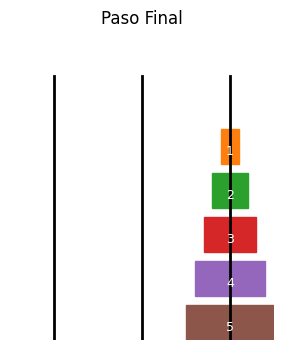

In [160]:
simulate_movements('sequence_star_a', 'initial_state_star_a')


# Ejecución/Simulación Greedy Search


In [161]:
#ejecutar el algoritmo
node, metrics, goal_node = greedy_search(5)


### Crear archivo `sequence_greedy.json` con los movimientos realizados

In [162]:
save_sequence('sequence_greedy')


### Crear archivo `initial_state_greedy.json` con el estado inicial

In [163]:
#crear el archivo initial_state_greedy
save_initial_state('initial_state_greedy')


### Simulación de los movimientos realizados por Greedy Search

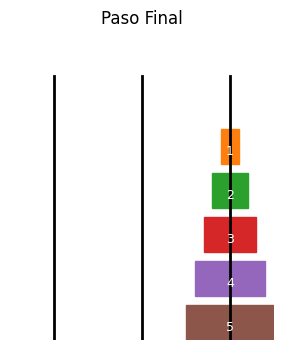

In [164]:
simulate_movements('sequence_greedy','initial_state_greedy')


# Ejecución Dijkstra

In [165]:
#ejecutar el algoritmo
node, metrics, goal_node = dijkstra_search(5)

### Crear archivo `sequence_dijkstra.json` con los movimientos realizados

In [166]:
save_sequence('sequence_dijkstra')

### Crear archivo `initial_state_dijkstra.json` con el estado inicial

In [167]:
save_initial_state('initial_state_dijkstra')

### Simulación de los movimientos realizados por Dijkstra Search

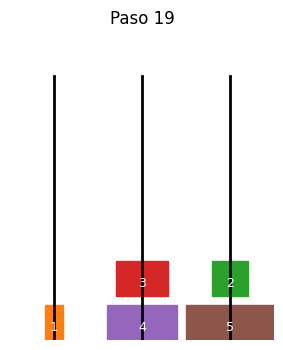

In [ ]:
simulate_movements('sequence_dijkstra','initial_state_dijkstra')

# Preguntas teóricas


## 1. ¿Cuáles son los PEAS de este problema?

- **Performance (desempeño):**
  - Alcanzar el estado objetivo (todos los discos apilados en orden decreciente en la varilla derecha).
  - Minimizar la cantidad de movimientos.
  - (Opcional) Minimizar el tiempo de ejecución.
  - (Opcional) Minimizar el uso de memoria.
- **Environment (entorno):**
  - 5 discos de distinto tamaño están inicialmente apilados en orden decreciente sobre la varilla izquierda, donde en ningun momento un disco puede estar colocado sobre otro de menor tamaño.
  - 3 varillas.
- **Actuators (actuadores):**
  - Mecanismo para mover discos: la única acción posible es trasladar el disco superior de una varilla a otra, especificando la varilla origen y la de destino.
- **Sensores (sensores):**
  - Lectura del estado actual de las varillas: acción de consultar en todo momento qué discos hay en cada varilla y en qué orden.

## 2. ¿Cuáles son las propiedades del entorno de trabajo?

Las propiedades del entorno de trabajo en el contexto de la Torre de Hanoi son:
- **Discreto:** el entorno tiene un número finito y contable de estados posibles. Cada acción cambia el estado de forma puntual y no existen transiciones continuas.
- **Totalmente observable:** se conoce en todo momento la posición exacta de cada disco en cada varilla. No hay información oculta.
- **Determinista:** cada acción tiene un resultado único y predecible. Mover un disco siempre produce el mismo cambio en el estado.
- **Estático:** el entorno no cambia por sí solo. Solo se modifica cuando el agente realiza una acción.
- **Secuencial:** la solución requiere una secuencia ordenada de movimientos donde cada acción depende de las anteriores para alcanzar el objetivo.
- **Agente individual:** hay un único agente encargado de realizar todos los movimientos de los discos. No hay interacción con otros agentes.

## 3. Defina los siguientes conceptos: Estado, Espacio de estados, Árbol de búsqueda, Nodo de búsqueda, Objetivo, Acción, Frontera

- **Estado:** representa una configuración específica de los discos en las tres varillas en un momento dado.
- **Espacio de estados:** es el conjunto de todos los estados posibles que se pueden alcanzar desde el estado inicial, aplicando las reglas del problema, es decir, mover un disco a la vez sin colocar un disco sobre uno de menor tamaño.
- **Árbol de búsqueda:** representa todas las posibles secuencias de movimientos desde el estado inicial hasta el estado objetivo. Es decir, todas las secuencias posibles para pasar de tener los discos apilados en orden decreciente en la varilla izquierda a tenerlos en ese mismo orden en la varilla derecha.
- **Nodo de búsqueda:** representa una configuración de los discos junto con el movimiento que se realizó para llegar a ella. Cada nodo guarda su estado anterior, lo que permite reconstruir la secuencia completa de movimientos desde el inicio.
- **Objetivo:** lograr que todos los discos se encuentren apilados en orden de tamaño decreciente en la varilla derecha.
- **Acción:** mover un único disco superior de una varilla a otra, sin colocarlo encima de un disco más pequeño que él.
- **Frontera:** conjunto de configuraciones de discos generadas por movimientos válidos desde estados anteriores, pero que aún no fueron exploradas para seguir generando nuevos movimientos. Es decir, son los próximos posibles movimientos a considerar en la búsqueda de la solución.

## 4. Implementación del algoritmo

Para la resolución de la Torre de Hanoi se implementaron los algoritmos de búsqueda Depth-First Search (DFS), Greedy y A*. (Referenciar al codigo)

## 5. ¿Cuál es la complejidad teórica en tiempo y memoria del algoritmo elegido?

A continuación se detalla la complejidad temporal y espacial de los algoritmos implementados. Es importante mencionar que, para este análisis:
- 𝑏 representa el factor de ramificación (cantidad de movimientos posibles por estado).
- 𝑚 es la profundidad máxima del árbol de búsqueda.
- 𝑑 es la profundidad de la solución más cercana.

| Algoritmo | Complejidad temporal | Complejidad espacial |
|-----------|----------------------|----------------------|
| DFS       | $O(𝑏^𝑚)$ | $O(𝑏.𝑑)$ |
| Greedy    | $O(𝑏^𝑚)$ | $O(𝑏^𝑚)$ |
| A*        | $O(𝑏^𝑑)$ | $O(𝑏^𝑑)$ |

- **DFS Depth-First Search:**
  - Complejidad temporal:** en el peor caso explora todo el árbol hasta profundidad máxima m.
  - **Complejidad espacial:** DFS guarda solo el camino actual en la pila de exploración, cuya profundidad máxima es d. En cada nivel pueden generarse hasta b nodos sucesores, por lo que en el peor caso la complejidad espacial es O(b·d).
- **Greedy:**
  - **Complejidad temporal:** puede expandir casi todo el espacio si la heurística es mala (peor caso), es decir hasta profundidad m.
  - **Complejidad espacial:** necesita almacenar todos los nodos en frontera + los explorados, por lo tanto también es O(b^m).
- **A*:**
  - **Complejidad temporal:** igual a O(b^d) en el peor caso, si la heurística es muy mala (casi nula).
  - **Complejidad espacial:** mantiene todos los nodos visitados y la frontera en memoria , así que también es O(b^d).

Estas complejidades corresponden al peor caso. Sin embargo, los algoritmos de búsqueda informada como Greedy y A* pueden ser significativamente más eficientes en la práctica si la heurística utilizada es adecuada. Una heurística se considera buena si es admisible (nunca sobreestima el costo real al objetivo) y, en el caso de A*, también consistente (cumple con la desigualdad triangular).

## 6. A nivel de implementación, ¿cuánto tiempo y memoria utiliza el algoritmo?

Referenciar a la tabla con las corridas realizadas.

## 7 ¿Qué tan lejos está la solución encontrada por el algoritmo implementado de esa solución óptima?

La solución óptima para la Torre de Hanoi con 5 discos es 31 movimientos.
A partir de los resultados obtenidos en las ejecuciones, se observa lo siguiente:
- **DFS:** encuentra la solución realizando en promedio 90 movimientos adicionales respecto de la solución óptima.
- **Greedy:** encuentra la solución realizando en promedio 5 movimientos adicionales.
- **A*:** encuentra la solución utilizando exactamente 31 movimientos, es decir, logra la solución óptima.